# Amazon Reviews for Sentiment Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
stop = set(stopwords.words("english"))

%matplotlib inline

2021-12-03 00:12:34.272524: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-03 00:12:34.272674: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import bz2
train = bz2.BZ2File('../input/amazonreviews/train.ft.txt.bz2')
test = bz2.BZ2File('../input/amazonreviews/test.ft.txt.bz2')
train_data = [x.decode('utf-8') for x in train.readlines()]
test_data = [x.decode('utf-8') for x in test.readlines()]

In [3]:
print(f"Training data count: {len(train_data)}")
print(f"Test data count: {len(test_data)}")

Training data count: 3600000
Test data count: 400000


In [4]:
def get_df(data_file):
    """ Reads data and creates the dataframe with sentence and label columns 
        Label:
        0 - Positive Review
        1 - Negative Review
    """
    labels = [1 if x.split(' ')[0] == "__label__1" else 0 for x in data_file]
    sentences = [x.split(" ", 1)[1][:-1].lower() for x in data_file]
    return pd.DataFrame({'text': sentences, 'label': labels})

In [5]:
train_df = get_df(train_data)[:50000]
test_df = get_df(test_data)[:10000]

In [6]:
pd.set_option('display.max_colwidth', None)
train_df.head()

,text,label
0,stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^,0
1,"the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny.",0
2,"amazing!: this soundtrack is my favorite music of all time, hands down. the intense sadness of ""prisoners of fate"" (which means all the more if you've played the game) and the hope in ""a distant promise"" and ""girl who stole the star"" have been an important inspiration to me personally throughout my teen years. the higher energy tracks like ""chrono cross ~ time's scar~"", ""time of the dreamwatch"", and ""chronomantique"" (indefinably remeniscent of chrono trigger) are all absolutely superb as well.this soundtrack is amazing music, probably the best of this composer's work (i haven't heard the xenogears soundtrack, so i can't say for sure), and even if you've never played the game, it would be worth twice the price to buy it.i wish i could give it 6 stars.",0
3,"excellent soundtrack: i truly like this soundtrack and i enjoy video game music. i have played this game and most of the music on here i enjoy and it's truly relaxing and peaceful.on disk one. my favorites are scars of time, between life and death, forest of illusion, fortress of ancient dragons, lost fragment, and drowned valley.disk two: the draggons, galdorb - home, chronomantique, prisoners of fate, gale, and my girlfriend likes zelbessdisk three: the best of the three. garden of god, chronopolis, fates, jellyfish sea, burning orphange, dragon's prayer, tower of stars, dragon god, and radical dreamers - unstealable jewel.overall, this is a excellent soundtrack and should be brought by those that like video game music.xander cross",0
4,"remember, pull your jaw off the floor after hearing it: if you've played the game, you know how divine the music is! every single song tells a story of the game, it's that good! the greatest songs are without a doubt, chrono cross: time's scar, magical dreamers: the wind, the stars, and the sea and radical dreamers: unstolen jewel. (translation varies) this music is perfect if you ask me, the best it can be. yasunori mitsuda just poured his heart on and wrote it down on paper.",0


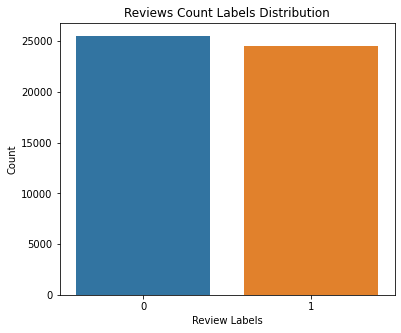

In [7]:
plt.figure(figsize=(6,5))
ax = sns.countplot(x="label", data=train_df)
plt.title('Reviews Count Labels Distribution')
plt.xlabel('Review Labels')
plt.ylabel('Count')
plt.show()

In [8]:
def clean_text(data):
    """ Normalize words and remove unwanted symbols and punctuation marks """
    # Convert data to lowercase
    data = str(data).lower()
    # Remove punctuation
    data = re.sub(r"[^\w\s]","",data)
    # Remove URL
    data = re.sub(r"^https?:\/\/.*[\r\n]*", "", data, flags=re.MULTILINE)
    # Remove HTML
    data = re.sub("<[^<]+?>", "", data)
    # Remove numbers
    data = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", data)
    # Remove line breaks
    data = re.sub("\n", "", data)
    # Remove punctuation
    translator = str.maketrans("", "", string.punctuation)
    return data.translate(translator)

In [9]:
def remove_punctuations(data):
    """ Remove punctuations """
    data = [words for words in data if words not in string.punctation]
    clean_data = "".join(no_punct)
    return clean_data

In [10]:
def remove_stopwords(text):
    """ Eliminates stop words """
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

In [11]:
def apply_lemmatization(sentence):
    """ Apply lemmatization """
    token_words = word_tokenize(sentence)
    new_words = [word for word in token_words if word.isalnum()]
    lemmatizer = WordNetLemmatizer()
    lemma_sentence = [lemmatizer.lemmatize(word) for word in new_words]
    return " ".join(lemma_sentence)

In [12]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Maps POS tag to lemmatizer """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def apply_lemmatization_with_pos_tag(sentence):
    """ Apply lemmatization with POS tag """
    lemmatizer = WordNetLemmatizer()
    lemma_sent = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(sentence)]
    return " ".join(lemma_sent)

In [13]:
def remove_emoji(text):
    regrex_pattern = re.compile(
        pattern="["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+",
        flags=re.UNICODE)
    return regrex_pattern.sub(r'', text)

In [14]:
def words_with_char_limit(sent, word_len=2):
    clean_sent = [word.strip().lower() for word in sent.strip().split() if len(word) > 2]
    return " ".join(clean_sent)

In [15]:
train_df['clean_text'] = train_df['text'].copy()
test_df['clean_text'] = test_df['text'].copy()

In [16]:
train_df['clean_text'] = train_df['clean_text'].apply(clean_text)
train_df['clean_text'] = train_df['clean_text'].apply(remove_emoji)
train_df['clean_text'] = train_df['clean_text'].apply(words_with_char_limit)
train_df['clean_text'] = train_df['clean_text'].apply(lambda x: remove_stopwords(x))
train_df['clean_text'] = train_df['clean_text'].apply(lambda x: apply_lemmatization_with_pos_tag(x))

test_df['clean_text'] = test_df['clean_text'].apply(clean_text)
test_df['clean_text'] = test_df['clean_text'].apply(remove_emoji)
test_df['clean_text'] = test_df['clean_text'].apply(words_with_char_limit)
test_df['clean_text'] = test_df['clean_text'].apply(lambda x: remove_stopwords(x))
test_df['clean_text'] = test_df['clean_text'].apply(lambda x: apply_lemmatization_with_pos_tag(x))

In [17]:
display(train_df.head(2))
display(test_df.head(2))

,text,label,clean_text
0,stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^,0,stun even nongamer sound track beautiful paint senery mind well would recomend even people hate vid game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen
1,"the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny.",0,best soundtrack ever anything reading lot review say best game soundtrack figure write review disagree bit opinino yasunori mitsudas ultimate masterpiece music timeless listen year beauty simply refuse fadethe price tag pretty stagger must say go buy much money one feel would worth every penny


,text,label,clean_text
0,"great cd: my lovely pat has one of the great voices of her generation. i have listened to this cd for years and i still love it. when i'm in a good mood it makes me feel better. a bad mood just evaporates like sugar in the rain. this cd just oozes life. vocals are jusat stuunning and lyrics just kill. one of life's hidden gems. this is a desert isle cd in my book. why she never made it big is just beyond me. everytime i play this, no matter black, white, young, old, male, female everybody says one thing ""who was that singing ?""",0,great lovely pat one great voice generation listen year still love good mood make feel well bad mood evaporates like sugar rain ooze life vocal jusat stuunning lyric kill one life hidden gem desert isle book never make big beyond everytime play matter black white young old male female everybody say one thing sing
1,"one of the best game music soundtracks - for a game i didn't really play: despite the fact that i have only played a small portion of the game, the music i heard (plus the connection to chrono trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. there is an incredible mix of fun, epic, and emotional songs. those sad and beautiful tracks i especially like, as there's not too many of those kinds of songs in my other video game soundtracks. i must admit that one of the songs (life-a distant promise) has brought tears to my eyes on many occasions.my one complaint about this soundtrack is that they use guitar fretting effects in many of the songs, which i find distracting. but even if those weren't included i would still consider the collection worth it.",0,one best game music soundtrack game didnt really play despite fact played small portion game music heard plus connection chrono trigger great well lead purchase soundtrack remains one favorite album incredible mix fun epic emotional song sad beautiful track especially like there many kind song video game soundtrack must admit one song lifea distant promise brought tear eye many occasionsmy one complaint soundtrack use guitar fret effect many song find distract even werent include would still consider collection worth


## Tokenizer

In [18]:
MAX_FEATURES = 4500
INPUT_LENGTH = 256
DIMENSIONS = 64

tokenizer = Tokenizer(num_words=MAX_FEATURES)

tokenizer.fit_on_texts(train_df['clean_text'])
tokenizer.fit_on_texts(test_df['clean_text'])

train_token = tokenizer.texts_to_sequences(train_df["clean_text"])
test_token = tokenizer.texts_to_sequences(test_df["clean_text"])

X_train = pad_sequences(train_token, maxlen=INPUT_LENGTH)
X_test = pad_sequences(test_token, maxlen=INPUT_LENGTH)

In [19]:
y_train = train_df["label"]
y_test =  test_df["label"]

In [20]:
print(f"X Train Shape: {X_train.shape}")
print(f"X Test Shape:  {X_test.shape}")
print(f"Y Train Shape: {y_train.shape}")
print(f"Y Test Shape:  {y_test.shape}")

X Train Shape: (50000, 256)
X Test Shape:  (10000, 256)
Y Train Shape: (50000,)
Y Test Shape:  (10000,)


# Model Evaluation Metrics

In [21]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
                             confusion_matrix, plot_precision_recall_curve)

def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    scores = [[accuracy, precision, recall, f1, auc]]
    df = pd.DataFrame(scores, columns=["Accuracy", "Precision", "Recall", "F1-Measure", "AUC"], index = [model_name])
    return df

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cm, fmt='g', annot=True, cmap="coolwarm")
    plt.show()

# Long Short-Term Memory (LSTM)

In [22]:
from tensorflow.keras.layers import (Embedding, SpatialDropout1D, LSTM, Dropout, Dense, Conv1D, Bidirectional)
from tensorflow.keras import Sequential
import tensorflow as tf

In [23]:
def show_train_val_accuracy(epochs, accuracy, val_accuracy):
    """ Plot Training and validation Accuracy """
    plt.plot(epochs, accuracy, 'r')
    plt.plot(epochs, val_accuracy, 'b')
    plt.title('Training and validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.show()
    
def show_train_val_loss(epochs, loss, val_loss):
    """ Plot Training and Validation Loss """
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [24]:
import tensorflow as tf
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# print(tpu_strategy.num_replicas_in_sync)

2021-12-03 00:24:11.966299: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-03 00:24:11.976688: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-03 00:24:11.976759: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-03 00:24:11.976803: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3767cff90e71): /proc/driver/nvidia/version does not exist
2021-12-03 00:24:11.984221: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [25]:
def lstm_model(max_features, dimensions, input_length, 
               lstm_layer, actv, lr, dropout, dense_layer=None):
    with tpu_strategy.scope():
        model = Sequential()
        model.add(Embedding(max_features, dimensions, input_length=input_length))
        model.add(LSTM(lstm_layer, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(lstm_layer, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(1, activation="sigmoid"))
        opt = tf.optimizers.Adam(learning_rate=lr)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    plot_model(model)
    return model

In [26]:
def bidirectional_lstm_model(max_features, dimensions, input_length, 
                             lstm_layer, dense_layer, actv, lr, dropout=.20):
    with tpu_strategy.scope():
        model = Sequential()
        model.add(Embedding(max_features, dimensions, input_length=input_length))
        model.add(SpatialDropout1D(dropout))
        model.add(Bidirectional(LSTM(lstm_layer)))
        model.add(Dropout(dropout))
        model.add(Dense(dense_layer, activation=actv))
        model.add(Dense(1, activation="sigmoid"))
        opt = tf.optimizers.Adam(learning_rate=lr)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    plot_model(model)
    return model

In [27]:
def run_lstm_model(X_train, X_test, y_train, y_test, param_config):
    batch_size = param_config.get("batch_size")
    epoches = param_config.get("epoches")
    model = param_config.get("model")
    model_history = model.fit(X_train,
                              y_train,
                              epochs=epoches, 
                              batch_size=batch_size, 
                              validation_split=0.20)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Model loss: {loss}")
    print(f"Model accuracy: {accuracy}")
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(len(accuracy))
    show_train_val_accuracy(epochs, accuracy, val_accuracy)
    show_train_val_loss(epochs, loss, val_loss)
    y_pred = model.predict(X_test)
    y_pred_bin = [1 if i >= 0.5 else 0 for i in y_pred]
    y_pred_bin = np.array(y_pred_bin)
    lstm_metrics = evaluate_model(y_test, y_pred_bin, "LSTM")
    display(lstm_metrics)
    plot_confusion_matrix(y_test, y_pred_bin)

In [28]:
BATCH_SIZE = 128

========== LSTM Model ==========
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 300)          1350000   
_________________________________________________________________
lstm (LSTM)                  (None, 256, 256)          570368    
_________________________________________________________________
dropout (Dropout)            (None, 256, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 2,445,937
Trainable params: 2,445,937
Non-trainable params: 0
_____________

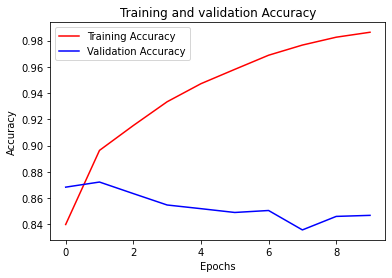

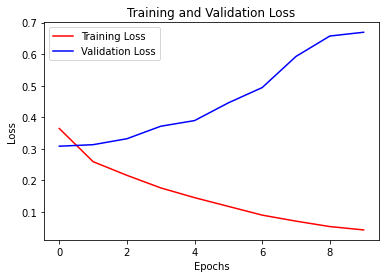

,Accuracy,Precision,Recall,F1-Measure,AUC
LSTM,0.8463,0.827383,0.865231,0.845884,0.846762


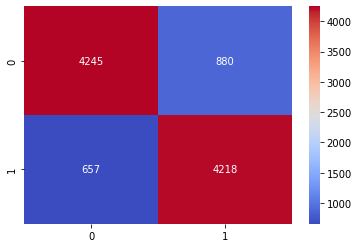

In [29]:
print("========== LSTM Model ==========")

lstm_param_config = {
    "batch_size": 64,
    "epoches": 10,
    "model": lstm_model(MAX_FEATURES, 300, INPUT_LENGTH,
                        lstm_layer=256, actv="relu", lr=0.001, dropout=.20)
}
run_lstm_model(X_train, X_test, y_train, y_test, lstm_param_config)

========== LSTM Model ==========
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 136)          612000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256, 256)          402432    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 256)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,540,001
Trainable params: 1,540,001
Non-trainable params: 0
___________

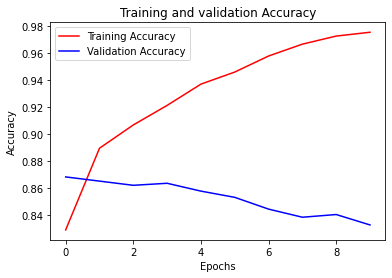

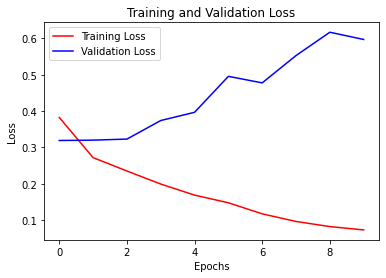

,Accuracy,Precision,Recall,F1-Measure,AUC
LSTM,0.8404,0.825362,0.853128,0.839016,0.84071


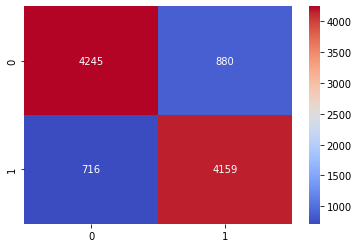

In [30]:
print("========== LSTM Model ==========")

lstm_param_config = {
    "batch_size": BATCH_SIZE,
    "epoches": 10,
    "model": lstm_model(MAX_FEATURES, 136, INPUT_LENGTH,
                        lstm_layer=256, actv="relu", lr=0.001, dropout=.20)
}
run_lstm_model(X_train, X_test, y_train, y_test, lstm_param_config)

========== LSTM Model ==========
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 128)          576000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 256, 300)          514800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256, 300)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 1,812,301
Trainable params: 1,812,301
Non-trainable params: 0
___________

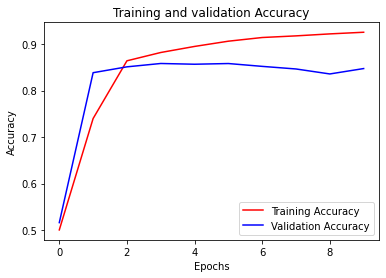

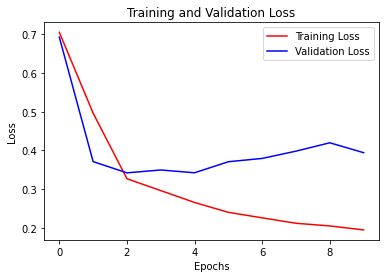

,Accuracy,Precision,Recall,F1-Measure,AUC
LSTM,0.8577,0.868017,0.835077,0.851228,0.857148


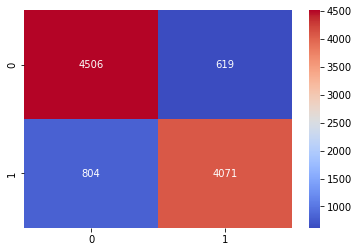

In [31]:
print("========== LSTM Model ==========")

lstm_param_config = {
    "batch_size": BATCH_SIZE,
    "epoches": 10,
    "model": lstm_model(MAX_FEATURES, 128, INPUT_LENGTH,
                        lstm_layer=300, actv="relu", lr=0.01, dropout=.20)
}
run_lstm_model(X_train, X_test, y_train, y_test, lstm_param_config)

========== Bidirectional LSTM Model ==========
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 256, 64)           288000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50)                18000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 34)                1734      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 35        
Total params: 307,769
Trainable params: 307,769
Non-trainable params: 0
_

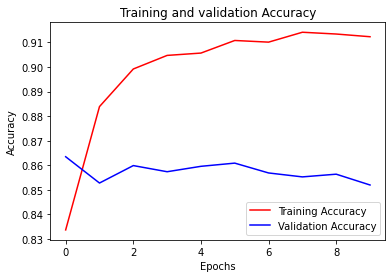

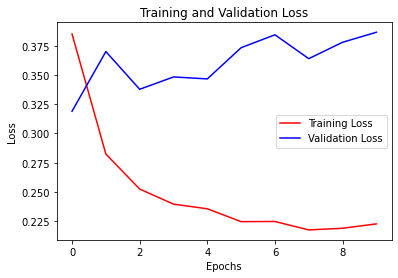

,Accuracy,Precision,Recall,F1-Measure,AUC
LSTM,0.8612,0.86713,0.844718,0.855777,0.860798


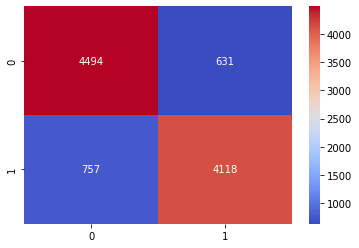

In [32]:
print("========== Bidirectional LSTM Model ==========")

bdlstm_param_config = {
    "batch_size": 32,
    "epoches": 10,
    "model": bidirectional_lstm_model(MAX_FEATURES, DIMENSIONS, INPUT_LENGTH,
                                      lstm_layer=25, dense_layer=34, actv="relu", lr=0.01)
}
run_lstm_model(X_train, X_test, y_train, y_test, bdlstm_param_config)

========== Bidirectional LSTM Model ==========
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 256, 64)           288000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 256, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50)                18000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 307,665
Trainable params: 307,665
Non-trainable params: 0
_

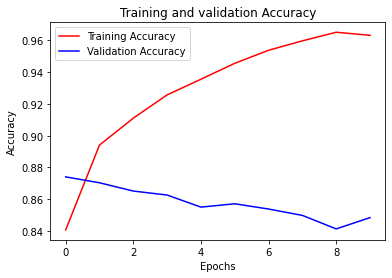

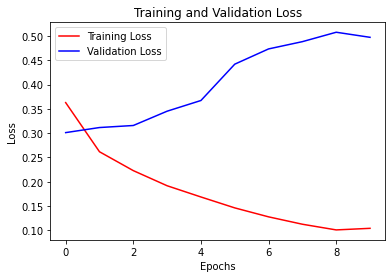

,Accuracy,Precision,Recall,F1-Measure,AUC
LSTM,0.8508,0.82915,0.874051,0.851009,0.851367


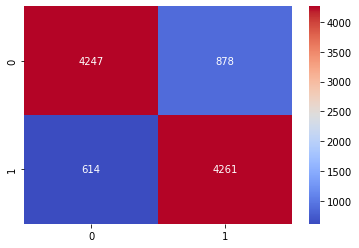

In [33]:
print("========== Bidirectional LSTM Model ==========")

bdlstm_param_config = {
    "batch_size": 32,
    "epoches": 10,
    "model": bidirectional_lstm_model(MAX_FEATURES, DIMENSIONS, INPUT_LENGTH,
                                      lstm_layer=25, dense_layer=32, actv="relu", lr=0.001)
}
run_lstm_model(X_train, X_test, y_train, y_test, bdlstm_param_config)

========== Bidirectional LSTM Model ==========
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 256, 200)          900000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 256, 200)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 512)               935936    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 80)                41040     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 81        
Total params: 1,877,057
Trainable params: 1,877,057
Non-trainable params

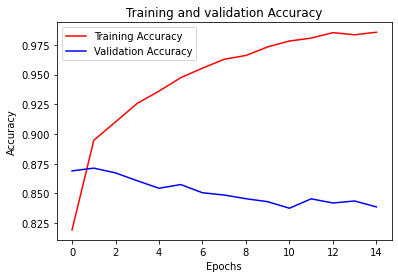

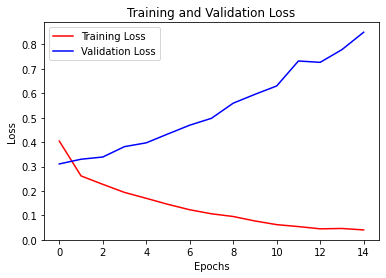

,Accuracy,Precision,Recall,F1-Measure,AUC
LSTM,0.8462,0.825943,0.867282,0.846108,0.846714


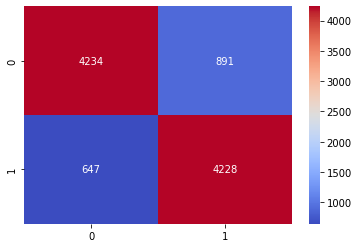

In [41]:
print("========== Bidirectional LSTM Model ==========")

bdlstm_param_config = {
    "batch_size": BATCH_SIZE,
    "epoches": 15,
    "model": bidirectional_lstm_model(MAX_FEATURES, 200, INPUT_LENGTH,
                                      lstm_layer=256, dense_layer=80, actv="relu", lr=0.001)
}
run_lstm_model(X_train, X_test, y_train, y_test, bdlstm_param_config)